## 0. Import des librairies

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
import keras
from keras import metrics
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation
import os
import pickle
import cv2

from src import import_auto      # Ma fonction == optimisation (voir import_auto.py)
from src import negatif_test

## 1. Optimisation et nettoyage des données

In [8]:
# Afin de réduire les temps d'attente et dans un soucis d'optimisation, je decide d'importer une fonction qui prend 200 png par lettres (suffisant ici). Ces images viennent s'ajouter au dossier dataset_reduit_train
import_auto.import_fichier_train()

In [9]:
# Afin de réduire les temps d'attente et dans un soucis d'optimisation, je decide d'importer une fonction qui prend 3 png par lettres (suffisant ici). Ces images viennent s'ajouter au dossier dataset_reduit_test
import_auto.import_fichier_test()

## 2. Import des Datasets

In [10]:
# ImageDataGenerator génère des lots de données d'image vectorielles, convertissant les coefficients RVB compris entre 0 et 255 en valeurs cibles comprises entre 0 et 1 par mise à l'échelle avec un facteur de 1/255 à l' aide de la remise à l' échelle

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,           # shear_range est utilisé pour appliquer de manière aléatoire des                                                                                                     transformations de cisaillement
                                   zoom_range = 0.2,            # zoom_range est utilisé pour zoomer aléatoirement à l'intérieur                                                                                                      des images
                                   horizontal_flip = True)      # horizontal_flip est utilisé pour retourner au hasard la moitié                                                                                                      des images horizontalement

test_datagen = ImageDataGenerator(rescale = 1./255)


# J'importe les images une par une à partir des répertoires en utilisant .flow_from_directory et y appliquons ImageDataGenerator.
train_generator = train_datagen.flow_from_directory(
    directory = "data/dataset_reduit_train",                    # Choix de mon repertoire
    target_size = (32,32),                                      # Je converti les images de leur taille d'origine à notre target_size
    batch_size = 32,                                            # Nombre batch_size qui fait référence au nombre d'exemples                                                                                                         d'entraînement utilisés dans une itération                                 
    class_mode = "categorical"                                  # Nous définissons le class_mode sur catégorique indiquant que                                                                                                        nous avons plusieurs classes (a à z) à prédire.

)

test_generator = test_datagen.flow_from_directory(
    directory = "data/dataset_reduit_test",
    target_size = (32,32),
    batch_size = 32,
    class_mode = "categorical"

)

Found 372451 images belonging to 27 classes.
Found 0 images belonging to 27 classes.


## 3. Definition du modèle d'architecture

In [11]:
# Création d'un modèle séquentiel qui permet de définir l'architecture CNN couche par couche à l'aide de la fonction .add .Nous ajoutons d'abord une couche de convolution avec 32 filtres de taille 3X3 sur les images d'entrée et la passons à travers la fonction d'activation 'relu'.Nous effectuons ensuite des opérations MaxPooling en utilisant un pool de taille 2X2 
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape = (32,32,3), activation = "relu"))
model.add(MaxPooling2D(pool_size = (2, 2)))

# Ces couches sont ensuite répétées à nouveau pour améliorer les performances du modèle.

model.add(Conv2D(32, (3, 3), activation = "relu"))
model.add(MaxPooling2D(pool_size = (2, 2)))

# Enfin, nous aplatissons notre matrice résultante et la passons à travers une couche dense composée de 128 nœuds. Celui-ci est ensuite connecté à la couche de sortie constituée de 26 nœuds, chaque nœud représentant un alphabet

model.add(Flatten())
model.add(Dense(units = 128, activation = "relu"))
model.add(Dense(units = 27, activation = "softmax"))            # Activation softmax qui convertit les scores en une distribution de probabilité normalisée, et le                                                                  nœud avec la probabilité la plus élevée est sélectionné comme sortie

# Une fois notre architecture CNN définie, nous compilons le modèle à l'aide de l'optimiseur Adam 
model.compile(optimizer = "adam", loss = "categorical_crossentropy", metrics = ["accuracy"])

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 13, 13, 32)        9248      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 6, 6, 32)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 1152)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               147584    
_________________________________________________________________
dense_4 (Dense)              (None, 27)               

## 4. Entrainement du modèle

In [6]:
# Je décide de créer 30 répétitions, et j'ai X2 les steps_per_epoch pour augmenter notre précision

entrainement = model.fit_generator(train_generator,
                         steps_per_epoch = 32,
                         epochs = 30,
                         validation_data = test_generator,
                         validation_steps = 32)

score = model.evaluate(train_generator, verbose=0)
print("Test de perte:", score[0])
print("Test de précision:", score[1])


Epoch 1/30
32/32 [==============================] - 10s 303ms/step - loss: 2.7685 - accuracy: 0.2412
Epoch 2/30
32/32 [==============================] - 9s 290ms/step - loss: 1.8612 - accuracy: 0.4893
Epoch 3/30
32/32 [==============================] - 10s 307ms/step - loss: 1.4105 - accuracy: 0.5869
Epoch 4/30
32/32 [==============================] - 9s 297ms/step - loss: 1.1566 - accuracy: 0.6475
Epoch 5/30
32/32 [==============================] - 9s 297ms/step - loss: 0.9480 - accuracy: 0.7012
Epoch 6/30
32/32 [==============================] - 10s 308ms/step - loss: 0.9503 - accuracy: 0.7070
Epoch 7/30
32/32 [==============================] - 12s 384ms/step - loss: 0.7553 - accuracy: 0.7783
Epoch 8/30
32/32 [==============================] - 11s 334ms/step - loss: 0.7535 - accuracy: 0.7705
Epoch 9/30
32/32 [==============================] - 10s 323ms/step - loss: 0.6844 - accuracy: 0.7939
Epoch 10/30
32/32 [==============================] - 10s 326ms/step - loss: 0.5909 - accuracy:

KeyboardInterrupt: 

## 5. Enregistrement & chargement du modèle

In [7]:
pickle.dump(model, open("mon_model.sav", "wb"))
model = pickle.load(open("mon_model.sav","rb"))

## 6. Création d'une fonction qui renvois l'alphabet associé au résultat

In [8]:
def get_result(result):
    if result[0][0] == 1:
        return("a")
    elif result[0][1] == 1:
        return ("b")
    elif result[0][2] == 1:
        return ("c")
    elif result[0][3] == 1:
        return ("d")
    elif result[0][4] == 1:
        return ("e")
    elif result[0][5] == 1:
        return ("f")
    elif result[0][6] == 1:
        return ("g")
    elif result[0][7] == 1:
        return ("h")
    elif result[0][8] == 1:
        return ("i")
    elif result[0][9] == 1:
        return ("j")
    elif result[0][10] == 1:
        return ("k")
    elif result[0][11] == 1:
        return ("l")
    elif result[0][12] == 1:
        return ("m")
    elif result[0][13] == 1:
        return ("n")
    elif result[0][14] == 1:
        return ("o")
    elif result[0][15] == 1:
        return ("p")
    elif result[0][16] == 1:
        return ("q")
    elif result[0][17] == 1:
        return ("r")
    elif result[0][18] == 1:
        return ("s")
    elif result[0][19] == 1:
        return ("t")
    elif result[0][20] == 1:
        return ("u")
    elif result[0][21] == 1:
        return ("v")
    elif result[0][22] == 1:
        return ("w")
    elif result[0][23] == 1:
        return ("x")
    elif result[0][24] == 1:
        return ("y")
    elif result[0][25] == 1:
        return ("z")
    elif result[0][26] == 1:                # Création du symbole <3
        return ("<3")

## 7. Choix de l'image à envoyer

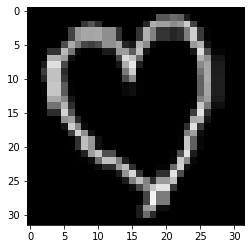

In [9]:
choix = r"assets\COEUR-thomas.png"
test_image = image.load_img(choix, target_size = (32,32))
plt.imshow(test_image)
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis = 0)


In [2]:
im = cv2.imread('assets\COEUR-thomas.png')
imgray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
ret, thresh = cv2.threshold(imgray, 127, 255, 0)
im2, contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

NameError: name 'cv2' is not defined

## 8. Test du modèle

In [10]:
resultat = model.predict(test_image)
resultat = get_result(resultat)
print(f"La lettre correspondante est: {resultat}")

La lettre correspondante est: <3


## 9. Import fonction negatif 

In [11]:
negatif_test.negatif("assets/imagedentrainement.jpeg", "assets/imagedentrainement_sortie.jpeg")

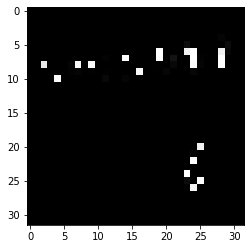

In [12]:
choix2 = r"assets/imagedentrainement_sortie.jpeg"
test_image2 = image.load_img(choix2, target_size = (32,32))
plt.imshow(test_image2)
test_image2 = image.img_to_array(test_image2)
test_image2 = np.expand_dims(test_image2, axis = 0)

In [13]:
#image_path
img_path="assets/imagedentrainement_sortie.jpeg"

In [14]:
#read image
img_raw = cv2.imread(img_path)

In [15]:
#select ROI function
roi = cv2.selectROI(img_raw)

In [16]:
#print rectangle points of selected roi
print(roi)

(79, 98, 1371, 125)


In [17]:
#Crop selected roi from raw image
roi_cropped = img_raw[int(roi[1]):int(roi[1]+roi[3]), int(roi[0]):int(roi[0]+roi[2])]

In [18]:
#show cropped image
cv2.imshow("ROI", roi_cropped)

In [19]:
 
cv2.imwrite("crop.jpeg",roi_cropped)
 
#hold window%
cv2.waitKey(0)